# Optimizing Model - Creating Average Delays

In [66]:
## Model Iteration 1
## Feature Eng: Average elapsed time by flight number (route), Average delay by carrier, 
##              Average NAS delay by flight number (route), Average Security delay by origin
## Purpose: To measure uplift of seperating delay averages into carrier,flight number (route), and origin delay
## Results : 
##      LightGBM Model RMSE is:  41.534851296809315 (-0.71% change)
##      LightGBM Model R2 Score is:  0.06627628680668773 (58.27% change)
##      LightGBM Model Cross-validation MAE is: 23.248054783196682 (-1.85% change)
##      XGBoostModel RMSE is:  42.594513295253144 (0.24% change)
##      XGBoost Model R2 Score is:  0.018025095840476513 (57.66% change)
##      XGBoost Model Cross-validation MAE is: 22.606841 (-0.03% change)

In [140]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
from scipy import stats
from sklearn.model_selection import train_test_split

In [141]:
data_flight_info = pd.read_csv('/Users/craiglynch/Desktop/Lighthouse_Labs/Mid-term_Project/mid-term-project-I-master/Regression_no_outliers_cleaned_data_03.csv', sep = ',')

In [142]:
df_flight_info = data_flight_info.copy()
df_flight_info.isnull().sum()

fl_date                0
mkt_unique_carrier     0
op_unique_carrier      0
op_carrier_fl_num      0
origin                 0
crs_dep_time           0
dep_time               0
dep_delay              0
dest                   0
arr_time               0
arr_delay              0
crs_arr_time           0
crs_elapsed_time       0
actual_elapsed_time    0
distance               0
carrier_delay          0
weather_delay          0
nas_delay              0
security_delay         0
late_aircraft_delay    0
year                   0
month                  0
day                    0
weekday                0
dtype: int64

In [143]:
#Only want top 19 busiest airports
airports = ['ORD','ATL','DFW','DEN','LAX','CLT','SEA','SFO','EWR','LGA','PHX','IAH','LAS','BOS','MCO','DTW','PHIL','DCA','MSP']
df_flight_info = df_flight_info[df_flight_info['origin'].isin(airports)]
df_flight_info.origin.value_counts()

ATL    48923
ORD    48428
DFW    35688
DEN    33907
LAX    30969
CLT    30851
SEA    23313
PHX    22252
SFO    22183
IAH    22017
DTW    21795
LAS    20661
LGA    20597
MSP    19965
EWR    19453
BOS    18365
MCO    17474
DCA    17438
Name: origin, dtype: int64

In [144]:
# Getting Average Carrier Delay - Grouped by Carrier
carrier_grouped = df_flight_info.groupby(by='op_unique_carrier').mean()
carrier_grouped.reset_index(inplace=True)
carrier_grouped['total_carrier_delay'] = carrier_grouped['carrier_delay'] + carrier_grouped['late_aircraft_delay']
carrier_grouped = carrier_grouped[['op_unique_carrier', 'total_carrier_delay']]

In [145]:
# Getting Average Security Delay
security_grouped = df_flight_info.groupby(by='origin').mean()
security_grouped.reset_index(inplace=True)
security_grouped['total_security_delay'] = security_grouped['security_delay']
security_grouped = security_grouped.drop(columns = ['op_carrier_fl_num','crs_dep_time','crs_elapsed_time','dep_delay','arr_delay','dep_time','arr_time','crs_arr_time','actual_elapsed_time','distance','carrier_delay','nas_delay','security_delay','late_aircraft_delay','weather_delay','year','month','day','weekday'])


In [146]:
# Finding average route times
df_flight_info['flight_number'] = df_flight_info['op_unique_carrier'] + df_flight_info['op_carrier_fl_num'].astype(str)
route_time_grouped = df_flight_info.groupby(by='flight_number').mean()
route_time_grouped.reset_index(inplace=True)
route_time_grouped['average_route_time'] = route_time_grouped['actual_elapsed_time']
route_time_grouped = route_time_grouped[['flight_number','average_route_time']]

In [147]:
# Getting Average NAS Delay
nas_grouped = df_flight_info.groupby(by='flight_number').mean()
nas_grouped.reset_index(inplace=True)
nas_grouped['total_nas_delay'] = nas_grouped['nas_delay']
nas_grouped = nas_grouped[['flight_number','total_nas_delay']]

In [148]:
# Getting Average Departure Delays by Route
dep_delay_grouped = df_flight_info.groupby(by='flight_number').mean()
dep_delay_grouped.reset_index(inplace=True)
dep_delay_grouped['total_dep_delay'] = dep_delay_grouped['dep_delay']
dep_delay_grouped = dep_delay_grouped[['flight_number','total_dep_delay']]

In [149]:
# Getting Average Arrival Delays by Route
arr_delay_grouped = df_flight_info.groupby(by='flight_number').mean()
arr_delay_grouped.reset_index(inplace=True)
arr_delay_grouped['total_arr_delay'] = arr_delay_grouped['arr_delay']
arr_delay_grouped = arr_delay_grouped[['flight_number','total_arr_delay']]

In [150]:
#Merge averages dataframes with original 
df_flight_info = df_flight_info.merge(security_grouped, on = 'origin', how = 'outer')
df_flight_info = df_flight_info.merge(nas_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(route_time_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(dep_delay_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(arr_delay_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(carrier_grouped, on = 'op_unique_carrier', how = 'outer')

# Model Training

In [151]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, r2_score, f1_score
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

## Feature Engineered Dataset

####  with Flight Number (onehot), average_route_time, total_security_delay, total_nas_delay

In [152]:
df_flight_info["flight_number"] = df_flight_info["flight_number"].astype('category').cat.codes

In [153]:
#### Shuffling dataset so model doesn't train on pattern

In [154]:
df_flight_info = shuffle(df_flight_info)
X = df_flight_info[['crs_dep_time','flight_number','crs_elapsed_time','crs_arr_time','average_route_time','distance','year','month','day','weekday','total_carrier_delay', 'total_security_delay','total_nas_delay']]
y = df_flight_info['arr_delay']

In [155]:
X.shape

(474279, 13)

In [156]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

##### LightGBM

In [157]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.08
params['boosting_type'] = 'gbdt'
#params['boosting_type'] = 'dart'
params['objective'] = 'regression'
params['metric'] = 'mse'
params['sub_feature'] = 0.5
params['num_leaves'] = 100
params['min_data'] = 5
params['max_depth'] = 100
y_train=y_train.ravel()
reg= lgb.train(params, d_train, 100)
results=reg.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, results)))
print('Model R2 Score is: ',r2_score(y_test,results))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1876
[LightGBM] [Info] Number of data points in the train set: 331995, number of used features: 13
[LightGBM] [Info] Start training from score 5.729177
Model RMSE is:  41.74468021034405
Model R2 Score is:  0.06086969460698455


In [158]:
# Cross-validate
cv_results = lgb.cv(
        params,
        d_train,
        num_boost_round=100,
        nfold=3,
        metrics='mae',
        early_stopping_rounds=10,

        stratified=False
        )
# Display results
print('Current parameters:\n', params)
print('\nBest num_boost_round:', len(cv_results['l1-mean']))
print('LightGBM Model Cross-validation MAE is:', cv_results['l1-mean'][-1])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1876
[LightGBM] [Info] Number of data points in the train set: 221330, number of used features: 13
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1876
[LightGBM] [Info] Number of data points in the train set: 221330, number of used features: 13
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1876
[LightGBM] [Info] Number of data points in the train set: 221330, number of used featur

##### XGBoost

In [159]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_test,y_test)

y_pred_xgb = xg_reg.predict(X_test)

print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_xgb))

Model RMSE is:  42.679955890038045
Model R2 Score is:  0.018316475739959648


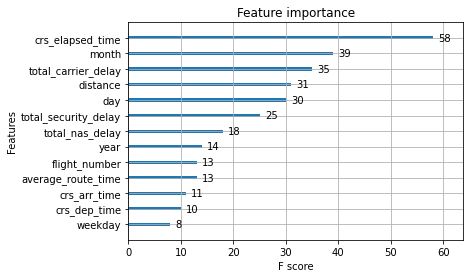

In [160]:
#Examine the importance of each feature column in the original data set with the model
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

In [161]:
params = {'objective':'reg:squarederror', 'colsample_bytree' : 0.3, 'learning_rate' : 0.1,
                'max_depth' : 5, 'alpha' : 10}
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="mae", as_pandas=True, seed=123)

print('XGBoost Model Cross-validation MAE is: ',(cv_results["test-mae-mean"]).tail(1))

XGBoost Model Cross-validation MAE is:  0    22.623687
Name: test-mae-mean, dtype: float64


##### Linear Regression

In [162]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X=scaler.fit_transform(X)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

# creating linear regression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_lr = lr.predict(X_test)

print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_lr)))
print('Model R2 Score is: ',r2_score(y_test,y_lr))

Model RMSE is:  42.78163372603004
Model R2 Score is:  0.03326120491831741


In [163]:
from numpy import mean
from numpy import absolute

#define cross-validation method to use
cv = KFold(n_splits=10, random_state=1, shuffle=True)

#build multiple linear regression model
model = lr

#use k-fold CV to evaluate model
scores = cross_val_score(model, X_test, y_test, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

#view mean absolute error
print('Linear Model Cross-validation MAE is: ',mean(absolute(scores)))

Linear Model Cross-validation MAE is:  23.894906997588613


##### Ridge/Lasso Regression

In [164]:
ridgereg = Ridge(alpha=0.001,normalize=True)
ridge = ridgereg.fit(X_train,y_train)
y_pred_ridge = ridge.predict(X_test)
print('Ridge Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print('Ridge Model R2 Score is: ',r2_score(y_test,y_pred_ridge))

lassoreg = Lasso(alpha=0.001,normalize=True)
lasso = lassoreg.fit(X_train,y_train)
y_pred_lasso = lasso.predict(X_test)
print('Lasso Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print('Lasso Model R2 Score is: ',r2_score(y_test,y_pred_lasso))

Ridge Model RMSE is:  42.78167632101393
Ridge Model R2 Score is:  0.0332592798752408
Lasso Model RMSE is:  42.80647212357449
Lasso Model R2 Score is:  0.03213832993659094


In [165]:
#define cross-validation method to use
cv = KFold(n_splits=10, random_state=1, shuffle=True)

#build multiple ridge regression model
model = ridgereg

#use k-fold CV to evaluate model
scores = cross_val_score(model, X_test, y_test, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

#view mean absolute error
print('Ridge Model Cross-validation MAE is: ',mean(absolute(scores)))

#build multiple lassp regression model
model = lassoreg

#use k-fold CV to evaluate model
scores = cross_val_score(model, X_test, y_test, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

#view mean absolute error
print('Lasso Model Cross-validation MAE is: ',mean(absolute(scores)))

Ridge Model Cross-validation MAE is:  23.89446413866511
Lasso Model Cross-validation MAE is:  23.871559659435132
